# *Mapbox*

In [ ]:
#Instal dependencies
!pip install polyline 
!pip install iso3166
!pip install boto3
!pip install supermercado
!pip install mercantile
!pip install rasterio
!apt install libspatialindex-dev
!pip install rtree
!pip install pygeos
!pip install geopandas
#import dependencies
import requests
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import sys
import geopandas as gpd
import numpy as np
import rasterio as rio
import rtree
from shapely.ops import cascaded_union
from shapely.geometry import Polygon,box
from PIL import Image
from mercantile import bounds
from supermercado.burntiles import burn
#Clone Mapbox-sdk-py (this repo is currently archieved!)
!git clone https://github.com/mapbox/mapbox-sdk-py.git
sys.path.append('/content/mapbox-sdk-py')
from mapbox import StaticStyle, Maps



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#useful functions :D

def poly_lonlat2pix(poly,bbox_bounds,img,width = None,height = None):
  if(img is not None):
    h,w = img.shape[:2]
  elif(None not in set([width,height])):
    h,w = height,width
  else:
    raise ValueError('Either Image or height and width should not be None')
  transform = rio.transform.from_bounds(*bbox_bounds,w,h)
  xs,ys = poly.exterior.xy
  rows,cols = rio.transform.rowcol(transform,xs,ys)
  coords = list(zip(cols,rows))
  return Polygon(coords)

def get_tiles_xyz(gdf,zoom_level):
  gdf_geo = gdf.__geo_interface__
  features  = gdf_geo['features']
  tiles_xyz = burn(features,zoom_level)
  return tiles_xyz

def get_covering_tiles(gdf,zoom_level):
  tiles_xyz = get_tiles_xyz(gdf,zoom_level)
  tiles_bboxs = []
  for xyz in tiles_xyz:
    _b = bounds(xyz)
    tiles_bboxs.append(box(*_b))
  return tiles_xyz,tiles_bboxs

def poly2gdf(poly,crs):
  return gpd.GeoDataFrame({'geometry':[poly]},crs=our_crs)

def encode_tile_id(tile_xyz):
  return 't_{}_{}_{}'.format(*tile_xyz)

def encode_tiles_ids(tiles_xyz):
  ids = [encode_tile_id(tile_xyz) for tile_xyz in tiles_xyz]
  return ids

def encode_multi_id(ids):
  return '&'.join(ids)

def decode_id(tile_id):
  return [*map(int,tile_id.lstrip('t_').split('_'))]

def decode_multi_id(multi_tile_id):
  return [decode_id(tid) for tid in multi_tile_id.split('&')]

#very specific functions
def _compress(gdf,_keys,id_key = 'FM_RE_ID'):
  keys = gdf.keys()
  _keys.extend(['tile_id'])
  assert(False not in [(k in keys ) for k in _keys]),'Missing keys from {}'.format(_keys)
  _keys[-1] = 'covering_tiles_ids'
  print(_keys)
  dic = {k : [] for k in _keys}
  uniq_fm_ids = gdf[id_key].unique()
  for i,fm_id in tqdm(enumerate(uniq_fm_ids)):
    query = gdf.loc[gdf[id_key] == fm_id] 
    values = [query[_k][query.index[0]] if(_k != id_key) else fm_id for _k in _keys[:-1] ]
    values.append(encode_multi_id(list(query['tile_id'])))
    for k,v in [*zip(_keys,values)]:dic[k].append(v)
  return gpd.GeoDataFrame(dic,crs=gdf.crs)

def get_covering_tiles_perloc(gdf,zoom_level,id_key = 'FM_RE_ID'):
  crs = gdf.crs
  tiles_xyz,tiles_bboxs = get_covering_tiles(gdf,zoom_level)
  tiles_ids = encode_tiles_ids(tiles_xyz)
  tiles_gdf = gpd.GeoDataFrame({'tile_id' : tiles_ids,
                                'geometry': tiles_bboxs,
                                },
                               crs = crs)
  joined = gpd.sjoin(gdf,tiles_gdf, how='left', op='intersects')
  del joined['index_right']
  joined.reset_index(inplace = True,drop = True) 
  return _compress(joined,[*gdf.keys()],id_key),tiles_gdf

def get_sample(fm_id,gdf,col = 'FMID_RE_ID'):
  query = gdf.loc[gdf[col]==fm_id]
  return query.loc[query.index[0]]

def get_tiles_bboxs(tiles_id,gdf,col = 'tile_id'):
  tiles_bboxs=[]
  for tile_id in tiles_ids:
    query = gdf.loc[gdf[col] == tile_id]
    tiles_bboxs.append(query['geometry'][query.index[0]])
  return tiles_bboxs





In [ ]:
#Class to request raster or static tiles
class Requestor():
  def __init__(self,request_type,access_token):
    self.valid_request_types = ['raster_tiles','static_tiles','vector_tiles']
    self.requestors = {
        'raster_tiles'  : Maps,
        'vector_tiles'  : Maps,
        'static_tiles'  : StaticStyle
    }
    self.access_token = access_token
    self.reset_request_type(request_type)

  def reset_request_type(self,request_type):
    assert request_type in self.valid_request_types,'{} is not a valid type,choose one from {}.'.format(request_typ,self.valid_request_types)
    self.request_type = request_type
    self.requestor = self.requestors[request_type](self.access_token)

  def request_tile(self,*args,**kwargs):
    return self.requestor.tile(*args,**kwargs)

  def request_tiles(self,tiles_xyz,*args,**kwargs):
    responces = []
    for tile_xyz in tiles_xyz:
      x,y,z = tile_xyz
      responces.append(self.request_tile(x=x,y=y,z=z,*args,**kwargs))
    return responces



In [ ]:
#list of AOI's that contain Silos (viewed on QGIS) for older shapefile:
aois = [
        10513726,
        10513720,
        10513797,
        10514105,        
        10514122,
        10514134,
        43489497,
        10514360,
        9446683,
        9448146,
        9450579,  
        10513727,
        ]

In [ ]:
#define properties
zoom_level = 17
size = 512 
double_dpi = True #double the image size
format = 'png256'
token = 'pk.eyJ1IjoidGFxYWRhbS1hZG1pbiIsImEiOiJja2dqdDN0OXYxczdmMnJycjJ3czYwa3QxIn0.mj7irXXPMaE9TL-xwrWdaw'
tileset_id = 'mapbox.satellite'#'mapbox.naip'#
style_id = 'satellite-v9'
username = 'mapbox'
our_crs = 'WGS84'

In [ ]:
#Read shape file of bins samples as gdf
shapefile_path = '/content/gdrive/MyDrive/SilosProject2021/bins_samples/bins_new_aoi.shp'
shapefile_path = '/content/gdrive/MyDrive/SilosProject2021/bins_samples2/bins_new_aoi_sample.shp'
shp_gdf = gpd.read_file(shapefile_path)
shp_gdf = shp_gdf.to_crs(our_crs)

In [ ]:
print(shp_gdf)
indices = []
for i,row in shp_gdf.iterrows():
  if(row['geometry'].geom_type != 'Polygon'):
    indices.append(i)
print(indices)
shp_gdf.drop(indices,inplace=True)
shp_gdf.reset_index(inplace = True,drop = True) 
print(shp_gdf)


In [ ]:

#Get all needed tiles to request to cover our AOI's for a specific zoom level
matched_gdf,tiles_gdf = get_covering_tiles_perloc(shp_gdf,zoom_level,id_key = 'AOI_ID')
print(f'We have {len(matched_gdf)} AOIs and we need {len(tiles_gdf)} tiles at a zoom level equal to {zoom_level} to cover these AOIs!')
#visualize a sample of AOI's and their covering tiles
count = 3
print('Visualizing {} AOIs(red) and their covering tiles(blue):'.format(count))
dec_ids = set()
for i,row in matched_gdf[:count].iterrows():
  dec_ids.update(row['covering_tiles_ids'].split('&'))
temp = tiles_gdf[tiles_gdf['tile_id'].isin([*dec_ids])]
geoms = temp['geometry']

fig,axs = plt.subplots(figsize = (15,4))
matched_gdf[:count].plot(ax = axs, color = 'red')

for geom in geoms:
    axs.plot(*geom.exterior.xy, color = 'blue')
plt.show()

In [ ]:
#get sample
#7,10,9,6
#9
ii = 10
#fm_id = aois[ii]
# 3288400,3288000
fm_id = 3047400
query = get_sample(fm_id,matched_gdf,'AOI_ID')
sample = query['geometry']
multi_id = query['covering_tiles_ids']
tiles_ids = multi_id.split('&')
tiles_xyz = decode_multi_id(multi_id)
tiles_bboxs = get_tiles_bboxs(tiles_ids,tiles_gdf)

#plot sample and covering tiles
fig,axs = plt.subplots(figsize = (4,4))
poly2gdf(sample,our_crs).plot(ax = axs,color='red')
for geom in tiles_bboxs:
  axs.plot(*geom.exterior.xy,color = 'blue')
plt.show()

In [ ]:
#Request a sample tile either 
request_type = 'raster_tiles'#'static_tiles'#

requestor = Requestor(request_type,token)
if(request_type == 'raster_tiles'):
  #make a raster raster tile request!
  responces_raster = requestor.request_tiles(
                                              tiles_xyz,
                                              map_id = tileset_id,
                                              retina = double_dpi, 
                                              file_format="png",
                                              style_id=None,
                                              timestamp=None
                                            )
  responces = responces_raster

elif(request_type == 'static_tiles'):
  responces_static = requestor.request_tiles(
                                              tiles_xyz,
                                              username = username, 
                                              style_id = style_id, 
                                              tile_size=size,
                                              retina=double_dpi
                                            )
else:
  raise ValueError('{} is not valid !!'.format(request_type))
print(responces)

[<Response [200]>, <Response [200]>]


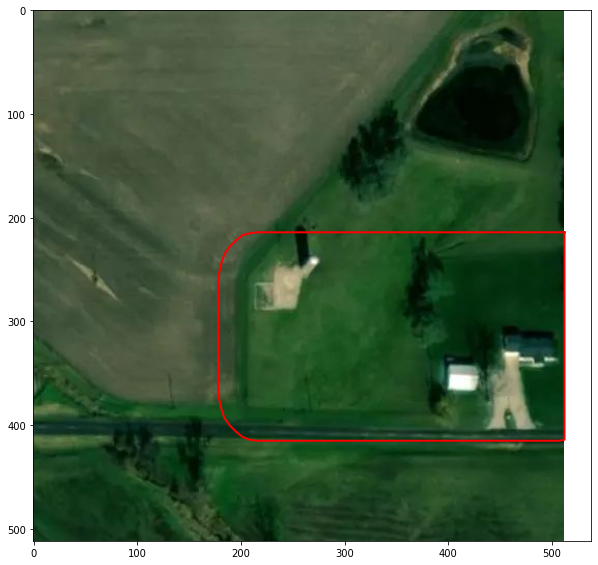

In [ ]:
#plot first tile to validate request
i = 0
open('image.png', 'wb').write(responces[i].content)
img = cv2.imread('image.png')[...,::-1]
tile_bounds = tiles_bboxs[i].bounds
intersection = tiles_bboxs[i].intersection(sample)
sample_pix = poly_lonlat2pix(intersection,tile_bounds,img)
fig,axs = plt.subplots(figsize = (10,10))
axs.imshow(img)

axs.plot( *sample_pix.exterior.xy,
          color='red', 
          linewidth=2)

In [ ]:
#GeoReference Image 
for i,xyz in enumerate(tiles_xyz):
  tid = f'{encode_tile_id(xyz)}_{tileset_id}'
  open(f'{tid}.png', 'wb').write(responces[i].content)
  img = cv2.imread(f'{tid}.png')[...,::-1]
  height,width = img.shape[:2]
  bbox = tiles_bboxs[i]
  bbox_bounds = bbox.bounds
  transform = rio.transform.from_bounds(*bbox_bounds,width,height)
  with rio.open(f'{tid}.tif','w+',
          driver='GTiff', width=width, height=height, count=3,
          crs=our_crs,transform=transform,dtype=img.dtype) as dst: 
          dst.write(np.ascontiguousarray(img.transpose(2,0,1),dtype = img.dtype))

In [ ]:
#copy png and tiffs to drive
def make_dir(path):
  try:
    os.makedirs(path)
  except:
    pass

drive_path = '/content/gdrive/MyDrive/pngs&tiffs-mapbox'
make_dir(drive_path)
files = [f  for f in os.listdir('/content') if(True in [x in f for x in ['.tif','.png']])]
print(files)
for f in files:
  ex = f.split('.')[-1]+'s'
  shutil.copyfile('/'.join(['/content',f]),'/'.join([drive_path,ex,f]))

['t_35450_48161_17_mapbox.satellite.png', 't_35450_48162_17_mapbox.satellite.png', 't_35450_48161_17_mapbox.satellite.tif', 't_35450_48162_17_mapbox.satellite.tif']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

{'attribution': '<a href="https://www.mapbox.com/about/maps/" target="_blank">&copy; Mapbox</a> <a href="http://www.openstreetmap.org/about/" target="_blank">&copy; OpenStreetMap</a> <a class="mapbox-improve-map" href="https://www.mapbox.com/map-feedback/" target="_blank">Improve this map</a> <a href="https://www.maxar.com/" target="_blank">&copy; Maxar</a>', 'autoscale': True, 'bounds': [-180, -85, 180, 85], 'cacheControl': 'max-age=43200,s-maxage=604800', 'center': [0, 0, 3], 'created': 1358310600000, 'id': 'mapbox.satellite', 'mapbox_logo': True, 'maxzoom': 22, 'minzoom': 0, 'modified': 1529608351000, 'name': 'Mapbox Satellite', 'private': False, 'scheme': 'xyz', 'tilejson': '2.2.0', 'tiles': ['http://a.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoidGFxYWRhbS1hZG1pbiIsImEiOiJja2dqdDN0OXYxczdmMnJycjJ3czYwa3QxIn0.mj7irXXPMaE9TL-xwrWdaw', 'http://b.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoidGFxYWRhbS1hZG1pbiIsImEiOiJja2d

In [ ]:
from datetime import datetime
from json import dump
res1= requestor.requestor.metadata(tileset_id)
tileset_metadata = res1.json()
with open('{}.json'.format(tileset_id),'w', encoding='utf-8') as f:
  dump(tileset_metadata,f, ensure_ascii=False, indent=4)
created_ts = tileset_metadata['created']/1000
modified_ts = tileset_metadata['modified']/1000
cr = datetime.fromtimestamp(created_ts)
mo = datetime.fromtimestamp(modified_ts)
print('Tileset \'{}\' was created on \'{}\' and last modified on \'{}\''.format(tileset_id,cr,mo))

Tileset 'mapbox.satellite' was created on '2013-01-16 04:30:00' and last modified on '2018-06-21 19:12:31'


In [ ]:
style_res = requests.get(f'https://api.mapbox.com/styles/v1/{username}/{style_id}?access_token={token}')
with open('{}.json'.format(style_id),'w', encoding='utf-8') as f:
  dump(style_res.json(),f, ensure_ascii=False, indent=4)